#Get data from drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Leadwise_data"

cpsc_leadclass_balanced_labels.npy  gtdata_lead_1.npy  labels_lead11.npy
cpsc_leadclass_balanced.npy	    gtdata_lead_2.npy  labels_lead1.npy
ecgsrcnn_100_labels.npy		    gtdata_lead_3.npy  labels_lead2.npy
ecgsrcnn_100op.npy		    gtdata_lead_4.npy  labels_lead3.npy
ecgsrcnn_125_labels.npy		    gtdata_lead_5.npy  labels_lead4.npy
ecgsrcnn_125op.npy		    gtdata_lead_6.npy  labels_lead5.npy
ecgsrcnn_250_labels.npy		    gtdata_lead_7.npy  labels_lead6.npy
ecgsrcnn_250op.npy		    gtdata_lead_8.npy  labels_lead7.npy
gtdata_lead_0.npy		    gtdata_lead_9.npy  labels_lead8.npy
gtdata_lead_10.npy		    labels_lead0.npy   labels_lead9.npy
gtdata_lead_11.npy		    labels_lead10.npy


#Acquire data: CPSC

In [ ]:
import numpy as np
#imbalanced dataset
ground_truth_cpsc_data = np.load("/content/drive/My Drive/gt_set.npy")
cpsc_labels = np.load("/content/drive/My Drive/cpsc_classlabels.npy")
print(len(ground_truth_cpsc_data))
print(len(cpsc_labels))

82524
82524


##Prepare event classification dataset

In [ ]:
leadwise_main_path = "/content/drive/My Drive/Leadwise_data/"

In [ ]:
import numpy as np
from sklearn.utils import shuffle

gt_balanced_ecg = np.load(leadwise_main_path + "cpsc_leadclass_balanced.npy")
gt_balanced_labels = np.load(leadwise_main_path + "cpsc_leadclass_balanced_labels.npy")

srcnn_250op = np.load(leadwise_main_path + "ecgsrcnn_250op.npy")
srcnn_250labels = np.load(leadwise_main_path + "ecgsrcnn_250_labels.npy")

srcnn_125op = np.load(leadwise_main_path + "ecgsrcnn_125op.npy")
srcnn_125labels = np.load(leadwise_main_path + "ecgsrcnn_125_labels.npy")

srcnn_100op = np.load(leadwise_main_path + "ecgsrcnn_100op.npy")
srcnn_100labels = np.load(leadwise_main_path + "ecgsrcnn_100_labels.npy")

temp_srcnn_op = np.concatenate((srcnn_250op,srcnn_125op,srcnn_100op),axis=0)
temp_srcnn_labels = np.concatenate((srcnn_250labels,srcnn_125labels,srcnn_100labels))

temp_srcnn_op_shuffled,temp_srcnn_labels_shuffled = shuffle(temp_srcnn_op,temp_srcnn_labels, random_state=42)
print(temp_srcnn_op_shuffled.shape)
print(temp_srcnn_labels_shuffled.shape)

(65448, 3000, 1)
(65448,)


##Injecting ECGSRCNN processed data to the prepared dataset

In [ ]:
#We inject 20% of ECG-SRCNN processed 
section_needed = np.int(0.2 * temp_srcnn_op_shuffled.shape[0])

srcnn_shuffledop_temp = np.reshape(temp_srcnn_op_shuffled,(temp_srcnn_op_shuffled.shape[0],temp_srcnn_op_shuffled.shape[1]))

complete_ecg_500set = np.concatenate((gt_balanced_ecg,srcnn_shuffledop_temp[:section_needed]),axis=0)
complete_ecg_500labels = np.concatenate((gt_balanced_labels,temp_srcnn_labels_shuffled[:section_needed]))

In [ ]:
srcnn_test_set = srcnn_shuffledop_temp[section_needed:srcnn_shuffledop_temp.shape[0]]
srcnn_test_labels = temp_srcnn_labels_shuffled[section_needed:temp_srcnn_labels_shuffled.shape[0]]

In [ ]:
print(complete_ecg_500set.shape)
print(complete_ecg_500labels.shape)
print(srcnn_test_set.shape)

(34905, 3000)
(34905,)
(52359, 3000)


#Normalization

Not required when the dataset is already within definite intervals

In [ ]:
def normaliseSignal(data):
  return ((data - np.mean(data)) / (np.max(data) - np.min(data))) + 0.5

In [ ]:
ecg_norm = normaliseSignal(ecg)
plt.plot(ecg_norm[:2700])

In [ ]:
normalized_set = []
for reading in ground_truth_cpsc_data:
  normalized_set.append(normaliseSignal(reading))

normalized_set = np.array(normalized_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
print(normalized_set.shape)

(82524, 3000)

#Denoising

Not required when using CPSC dataset. This is because CPSC dataset is quite clean dataset, and further denoising will lead to loss of crucial ECG information.

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, UpSampling1D
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU, Subtract, Reshape
from IPython.display import SVG

from time import time
import numpy as np

In [ ]:
raw_data = []
raw_target = []
for reading in afdb_signals_0:
  raw_data.append(normaliseSignal(reading))
  raw_target.append(0)
for reading in afdb_signals_1:
  raw_data.append(normaliseSignal(reading)) 
  raw_target.append(0)
for reading in vfdb_signals_0:
  raw_data.append(normaliseSignal(reading)) 
  raw_target.append(1)
for reading in vfdb_signals_1:
  raw_data.append(normaliseSignal(reading))
  raw_target.append(1)
for reading in nsrdb_signals_0:
  raw_data.append(normaliseSignal(reading)) 
  raw_target.append(2)
for reading in nsrdb_signals_1:
  raw_data.append(normaliseSignal(reading))
  raw_target.append(2)

print(len(raw_data))
print(len(raw_target))

126
126


In [ ]:
#To check saved model
new_model = tf.keras.models.load_model('/content/drive/My Drive/unet1d_new.h5')

# Show the model architecture
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3600, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3600, 12)     252         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3600, 12)     2892        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 3600, 12)     2892        conv1d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
def denoise_ECG_data(signal_db):
  all_chunk_indices = []
  all_chunks = []
  i = 0
  while(i<len(signal_db)):
    all_chunk_indices.append(i)
    i += 3600

  for j in all_chunk_indices:
    if j+3600 <= len(signal_db):
      all_chunks.append(signal_db[j:j+3600])
    else:
      temp = signal_db[j:len(signal_db)]
      temp_chunk = np.pad(temp,(0,3600-len(temp)),'constant',constant_values=(0))
      all_chunks.append(temp_chunk)

  readings = np.array(all_chunks)
  reconstructions = new_model.predict(readings)
  den_signal = reconstructions.ravel()
  fin_den_sig = den_signal[: len(signal_db)]
  return fin_den_sig

In [ ]:
denoised_ecgs = []
for i in range(len(raw_data)):
  temp_denoised = denoise_ECG_data(raw_data[i])
  denoised_ecgs.append(temp_denoised)
print(len(denoised_ecgs))

126


#Comparison study for 2/3/5/6/7 classes

This section is only for ablation study of event classification

In [ ]:
import numpy as np

ecg_normal = []
ecg_af = []
ecg_iavb = []
ecg_lbbb = []
ecg_rbbb = []
ecg_pac = []
ecg_pvc = []
ecg_std = []
ecg_ste = []

for i in cpsc_labels:
  if i == 1:
    ecg_normal.append(normalized_set[i])
  elif i == 2:
    ecg_af.append(normalized_set[i])
  elif i == 3:
    ecg_iavb.append(normalized_set[i])
  elif i == 4:
    ecg_lbbb.append(normalized_set[i])
  elif i == 5:
    ecg_rbbb.append(normalized_set[i])
  elif i == 6:
    ecg_pac.append(normalized_set[i])
  elif i == 7:
    ecg_pvc.append(normalized_set[i])
  elif i == 8:
    ecg_std.append(normalized_set[i])
  elif i == 9:
    ecg_ste.append(normalized_set[i])

##To handle class imbalance

In [ ]:
min_readings_classwise = min(len(ecg_normal),len(ecg_af),len(ecg_iavb),len(ecg_lbbb),
                             len(ecg_rbbb),len(ecg_pac),len(ecg_pvc),len(ecg_std),len(ecg_ste))
print(min_readings_classwise)

2424

In [ ]:
ecg_normal = ecg_normal[:min_readings_classwise]
ecg_af = ecg_af[:min_readings_classwise]
ecg_iavb = ecg_iavb[:min_readings_classwise]
ecg_lbbb = ecg_lbbb[:min_readings_classwise]
ecg_rbbb = ecg_rbbb[:min_readings_classwise]
ecg_pac = ecg_pac[:min_readings_classwise]
ecg_pvc = ecg_pvc[:min_readings_classwise]
ecg_std = ecg_std[:min_readings_classwise]
ecg_ste = ecg_ste[:min_readings_classwise]

In [ ]:
normal_labels = np.ones(len(ecg_normal))  ###1
af_labels = 2 * np.ones(len(ecg_af)) ####2
iavb_labels = 3 * np.ones(len(ecg_iavb)) ###3
lbbb_labels = 4 * np.ones(len(ecg_lbbb)) ###4
rbbb_labels = 5 * np.ones(len(ecg_rbbb)) ###5
pac_labels = 6 * np.ones(len(ecg_pac)) ###6
pvc_labels = 7 * np.ones(len(ecg_pvc)) ###7
std_labels = 8 * np.ones(len(ecg_std)) ###8
ste_labels = 9 * np.ones(len(ecg_ste)) ###9

In [ ]:
binary_dataset_ecg = np.concatenate((ecg_normal,ecg_af),axis = 0)
ternary_dataset_ecg = np.concatenate((ecg_normal,ecg_af,ecg_iavb),axis = 0)
pentanary_dataset_ecg = np.concatenate((ecg_normal,ecg_af,ecg_iavb,ecg_lbbb,ecg_rbbb),axis=0)
hexanary_dataset_ecg = np.concatenate((ecg_normal,ecg_af,ecg_iavb,ecg_lbbb,ecg_rbbb,ecg_pac),axis=0)
septanary_dataset_ecg = np.concatenate((ecg_normal,ecg_af,ecg_iavb,ecg_lbbb,ecg_rbbb,ecg_pac,ecg_pvc),axis=0)
complete_balanced_set = np.concatenate((ecg_normal,ecg_af,ecg_iavb,ecg_lbbb,ecg_rbbb,
                                        ecg_pac,ecg_pvc,ecg_std,ecg_ste),axis=0)

In [ ]:
print(len(complete_balanced_labels))

21816

In [ ]:
binary_dataset_labels = np.concatenate((normal_labels,af_labels))
ternary_dataset_labels = np.concatenate((normal_labels,af_labels,iavb_labels))
pentanary_dataset_labels = np.concatenate((normal_labels,af_labels,iavb_labels,lbbb_labels,rbbb_labels))
hexanary_dataset_labels = np.concatenate((normal_labels,af_labels,iavb_labels,lbbb_labels,rbbb_labels,pac_labels))
septanary_dataset_labels = np.concatenate((normal_labels,af_labels,iavb_labels,lbbb_labels,rbbb_labels,pac_labels,pvc_labels))
complete_balanced_labels = np.concatenate((normal_labels,af_labels,iavb_labels,lbbb_labels,
                                           rbbb_labels,pac_labels,pvc_labels,std_labels,ste_labels))

This temporary set is only classwise balanced, not leadwise

In [ ]:
np.save("complete_balanced_cpsc",complete_balanced_set)
np.save("complete_balanced_labelscpsc",complete_balanced_labels)

In [ ]:
import shutil

shutil.move('complete_balanced_cpsc.npy', "/content/drive/My Drive/")
shutil.move('complete_balanced_labelscpsc.npy', "/content/drive/My Drive/")

'/content/drive/My Drive/complete_balanced_labelscpsc.npy'

#Classification

##Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, Flatten
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, UpSampling1D
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU, Subtract, Reshape
from IPython.display import SVG
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from time import time
import numpy as np

##CPSC Data split

In [ ]:
#Change the name of dataset, abels set and number of classes here for ablation study

ecg_final_data_set = complete_ecg_500set
ecg_final_data_labels = complete_ecg_500labels
n_classes = 9

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_shuffled,y_shuffled = shuffle(ecg_final_data_set,ecg_final_data_labels, random_state=42)
ecg_train, X_test_temp, labels_train, y_test_temp = train_test_split(X_shuffled, y_shuffled, test_size=0.3, random_state=42)

ecg_validate, ecg_test,labels_validate,labels_test = train_test_split(X_test_temp,y_test_temp,test_size=0.5, random_state=42)

In [ ]:
labels_train_onehot = tf.one_hot(labels_train,n_classes)
labels_validate_onehot = tf.one_hot(labels_validate,n_classes)
labels_test_onehot = tf.one_hot(labels_test,n_classes)

In [ ]:
labels_srcnnop = tf.one_hot(srcnn_test_labels,n_classes)

##Handling one hot labels

In [ ]:
#For binary case convert class labels from 1,2 to 0,1; and change last dense 
#layer to have single node and optimizer will be binary cross entropy

In [ ]:
#handling one hot labels when labels dont begin with 0 and when number of classes more than 2
import copy

def get_modified_onehotlabels(tf_one_hot_labels,n_classes):
  default_onehot = np.array(tf_one_hot_labels)
  if n_classes == 3:
    zerocol_last = default_onehot[:, [1,2,0]]
  elif n_classes == 5:
    zerocol_last = default_onehot[:, [1,2,3,4,0]]
  elif n_classes == 6:
    zerocol_last = default_onehot[:, [1,2,3,4,5,0]]
  elif n_classes == 7:
    zerocol_last = default_onehot[:, [1,2,3,4,5,6,0]]
  elif n_classes == 9:
    zerocol_last = default_onehot[:, [1,2,3,4,5,6,7,8,0]]
  onehot_modified = copy.deepcopy(zerocol_last)
  for item in onehot_modified:
    if 1 not in item:
      item[onehot_modified.shape[1] - 1] = 1
  return onehot_modified

In [ ]:
labels_train_onehot_mod = get_modified_onehotlabels(labels_train_onehot,n_classes)
labels_validate_onehot_mod = get_modified_onehotlabels(labels_validate_onehot,n_classes)
labels_test_onehot_mod = get_modified_onehotlabels(labels_test_onehot,n_classes)

In [ ]:
labels_train_onehot_mod = labels_train_onehot_mod.astype(int)
labels_validate_onehot_mod = labels_validate_onehot_mod.astype(int)
labels_test_onehot_mod = labels_test_onehot_mod.astype(int)

In [ ]:
labels_train = labels_train.astype(int)
labels_validate = labels_validate.astype(int)
labels_test = labels_test.astype(int)

In [ ]:
labels_srcnnop_1hot_mod = get_modified_onehotlabels(labels_srcnnop,n_classes)
labels_srcnnop_1hot_mod = labels_srcnnop_1hot_mod.astype(int)

In [ ]:
print(labels_train[2])
print(labels_train_onehot[2])
print(labels_train_onehot_mod[2])

4
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(9,), dtype=float32)
[0 0 0 1 0 0 0 0 0]


In [ ]:
print(len(labels_train_onehot_mod))

24433


##Dataset reshaping

In [ ]:
input_shape = 3000, 1
num_classes = n_classes

In [ ]:
X_train_cnn = np.reshape(ecg_train,(ecg_train.shape[0],ecg_train.shape[1],1))
X_valid_cnn = np.reshape(ecg_validate,(ecg_validate.shape[0],ecg_validate.shape[1],1))
X_test_cnn = np.reshape(ecg_test,(ecg_test.shape[0],ecg_test.shape[1],1))

temp = np.concatenate((ecg_test,srcnn_test_set),axis=0)
complete_test_cnn = np.reshape(temp,(temp.shape[0],temp.shape[1],1))
complete_test_cnn_labels = np.concatenate((labels_test,srcnn_test_labels))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)
print(X_test_cnn.shape)
print(complete_test_cnn.shape)
print(complete_test_cnn_labels.shape)

(24433, 3000, 1)
(5236, 3000, 1)
(5236, 3000, 1)
(57595, 3000, 1)
(57595,)


##Ablation study: 3 networks for comparison

###1D-CNN : 10 layers

This network was used for comparison study for event-classification ablation study

In [ ]:
input = Input(input_shape)

model = Sequential()
model.add(Conv1D(32,5,activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv1D(32,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(64,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))
model.add(Conv1D(64,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(128,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))
model.add(Conv1D(128,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))
model.add(Dropout(0.5))

model.add(Conv1D(256,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))
model.add(Conv1D(256,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(512,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))
model.add(Conv1D(512,5,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2996, 32)          192       
_________________________________________________________________
batch_normalization (BatchNo (None, 2996, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2992, 32)          5152      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1496, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1492, 64)          10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 746, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 742, 64)           2

###1D-CNN (13 Layers)

This network is replicated from the paper: https://www.sciencedirect.com/science/article/pii/S0167739X20305410

In [ ]:
input = Input(input_shape)

model = Sequential()
model.add(Conv1D(64,3,activation = 'relu',input_shape = input_shape))
model.add(Conv1D(64,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(128,3,activation = 'relu'))
model.add(Conv1D(128,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(256,3,activation = 'relu'))
model.add(Conv1D(256,3,activation = 'relu'))
model.add(Conv1D(256,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(512,3,activation = 'relu'))
model.add(Conv1D(512,3,activation = 'relu'))
model.add(Conv1D(512,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(512,3,activation = 'relu'))
model.add(Conv1D(512,3,activation = 'relu'))
model.add(Conv1D(512,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Flatten())
model.add(Dense(1000, activation='tanh'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2998, 64)          256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2996, 64)          12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1498, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1496, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1494, 128)         49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 747, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 745, 256)          9

###1D CNN: 1 layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Dropout, Conv1D
from tensorflow.keras.utils import to_categorical

model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu',input_shape = (3000,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(9, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2996, 128)         768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2996, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 383488)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 3451401   
Total params: 3,452,169
Trainable params: 3,452,169
Non-trainable params: 0
_________________________________________________________________


###Proposed 1DCNN: 5 layers

This is the proposed model for event classification

In [ ]:
input = Input(input_shape)

model = Sequential()
model.add(Conv1D(64,3,activation = 'relu',input_shape = input_shape))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(128,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(256,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(512,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Conv1D(512,3,activation = 'relu'))
model.add(MaxPool1D(strides=2))

model.add(Flatten())
model.add(Dense(1000, activation='tanh'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2998, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1499, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1497, 128)         24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 748, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 746, 256)          98560     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 373, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 371, 512)          3

##Compile and train the model

In [ ]:
K.clear_session()
optimizer = Adam(learning_rate=0.0001) 
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer=optimizer, metrics=['categorical_accuracy'])

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
model.fit(X_train_cnn, labels_train_onehot_mod, epochs = 10,batch_size=64, validation_data=(X_valid_cnn,labels_validate_onehot_mod), verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
382/382 [==============================] - 71s 106ms/step - loss: 0.0481 - categorical_accuracy: 0.9894 - val_loss: 1.1811e-05 - val_categorical_accuracy: 1.0000
Epoch 2/10
382/382 [==============================] - 38s 101ms/step - loss: 4.1578e-06 - categorical_accuracy: 1.0000 - val_loss: 2.1302e-06 - val_categorical_accuracy: 1.0000
Epoch 3/10
382/382 [==============================] - 39s 102ms/step - loss: 1.0829e-06 - categorical_accuracy: 1.0000 - val_loss: 8.3085e-07 - val_categorical_accuracy: 1.0000
Epoch 4/10
382/382 [==============================] - 41s 108ms/step - loss: 4.9200e-07 - categorical_accuracy: 1.0000 - val_loss: 4.4001e-07 - val_categorical_accuracy: 1.0000
Epoch 5/10
382/382 [==============================] - 39s 102ms/step - loss: 2.7701e-07 - categorical_accuracy: 1.0000 - val_loss: 2.6860e-07 - val_categorical_accuracy: 1.0000
Epoch 6/10
382/382 [==============================] - 41s 108ms/step - loss: 1.7562e-07 - categorical_accuracy: 1.0000 

##Saving the model for later usage


In [ ]:
model.save('ECG_1DCNN_9classes_srcnn20percent.h5') 

In [ ]:
import shutil

shutil.move('ECG_1DCNN_9classes_srcnn20percent.h5',"/content/drive/My Drive/")

'/content/drive/My Drive/ECG_1DCNN_9classes_srcnn20percent.h5'

##Get schematic of model

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

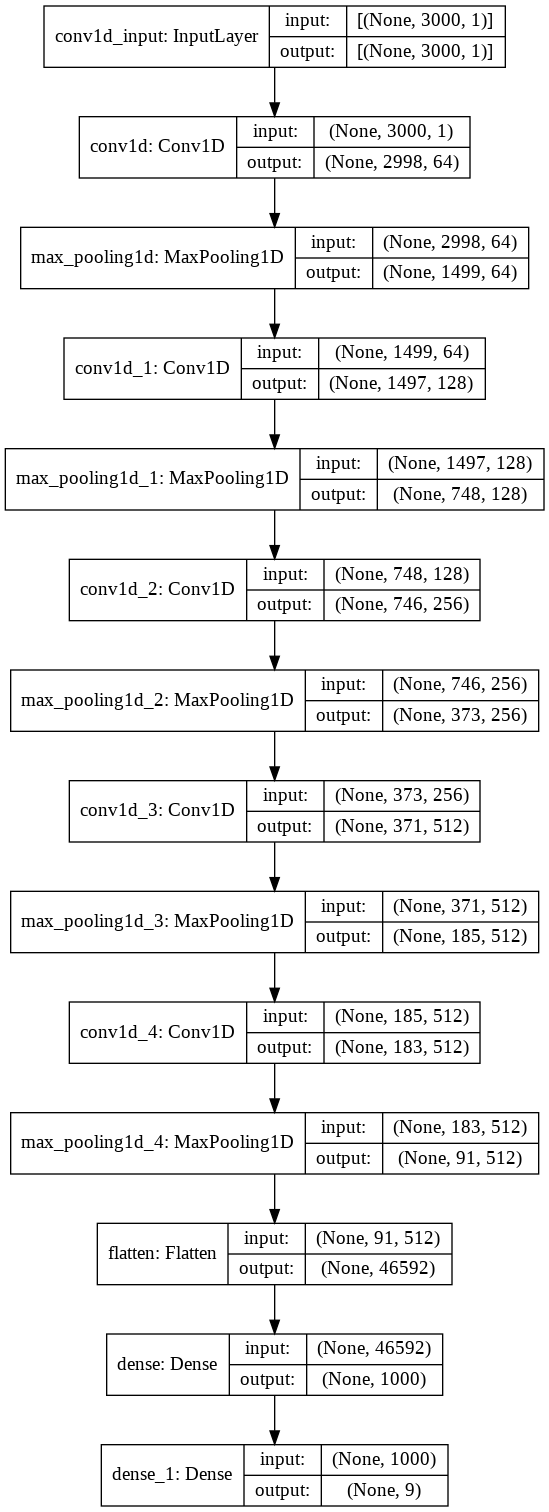

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='ECG_event_cnn.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

##Testing

In [ ]:
model.evaluate(X_test_cnn,labels_test_onehot_mod)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


164/164 [==============================] - 4s 21ms/step - loss: 5.0111e-08 - categorical_accuracy: 1.0000


[5.011056458670282e-08, 1.0]

In [ ]:
event_model = tf.keras.models.load_model('/content/drive/My Drive/ECG_1DCNN_9classes_srcnn20percent.h5')

In [ ]:
temp_test_srcnnlabels = tf.one_hot(complete_test_cnn_labels,n_classes)
final_complete_Setlabels = get_modified_onehotlabels(temp_test_srcnnlabels,n_classes)

In [ ]:
event_model.evaluate(complete_test_cnn,final_complete_Setlabels)

#Functions to calculate metrics

Here we calculate common metrics like accuracy and F1 score to analyse the performance of the network.

In [ ]:
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score

def print_report(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    
    recall = recall_score(y_actual, y_pred, average='micro')
    precision = precision_score(y_actual, y_pred, average='micro')
    score_f1 = f1_score(y_actual, y_pred, average='micro')
    
    print("Accuracy:",accuracy)
    print("Recall:",recall)
    print("Precision:",precision)
    print("F1_score:",score_f1)
    print("\n")

In [ ]:
y_train_preds_dense = event_model.predict(X_train_cnn,verbose = 1)
y_valid_preds_dense = event_model.predict(X_valid_cnn,verbose = 1)
y_test_preds_dense = event_model.predict(X_test_cnn,verbose = 1)

  7/764 [..............................] - ETA: 14s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


164/164 [==============================] - 2s 14ms/step


In [ ]:
predict_op_complete_test = event_model.predict(complete_test_cnn, verbose=1)

   9/1800 [..............................] - ETA: 26s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1800/1800 [==============================] - 26s 14ms/step


In [ ]:
srcnn_test_set_cnn = np.reshape(srcnn_test_set,(srcnn_test_set.shape[0],srcnn_test_set.shape[1],1))

In [ ]:
srcnn_test_labels_1hotmod = get_modified_onehotlabels(labels_srcnnop,n_classes)

In [ ]:
srcnn_op_labels_events = event_model.predict(srcnn_test_set_cnn,verbose = 1)

   7/1637 [..............................] - ETA: 32s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1637/1637 [==============================] - 23s 14ms/step


In [ ]:
def get_int_labels(pred_op_onehot,n_classes):

  final_labels_int = []
  
  if n_classes == 3:
    for i in pred_op_onehot:
      if i[0] == 1:
        final_labels_int.append(1)
      elif i[1] == 1:
        final_labels_int.append(2)
      elif i[2] == 1:
        final_labels_int.append(3)

  elif n_classes == 5:
    for i in pred_op_onehot:
      inde_max = np.where(i == np.max(i))
      
      if inde_max[0][0] == 0:
        final_labels_int.append(1)
      elif inde_max[0][0] == 1:
        final_labels_int.append(2)
      elif inde_max[0][0] == 2:
        final_labels_int.append(3)
      elif inde_max[0][0] == 3:
        final_labels_int.append(4)
      elif inde_max[0][0] == 4:
        final_labels_int.append(5)
  
  elif n_classes == 6:
    for i in pred_op_onehot:
      inde_max = np.where(i == np.max(i))
      
      if inde_max[0][0] == 0:
        final_labels_int.append(1)
      elif inde_max[0][0] == 1:
        final_labels_int.append(2)
      elif inde_max[0][0] == 2:
        final_labels_int.append(3)
      elif inde_max[0][0] == 3:
        final_labels_int.append(4)
      elif inde_max[0][0] == 4:
        final_labels_int.append(5)
      elif inde_max[0][0] == 5:
        final_labels_int.append(6)
  
  elif n_classes == 9:
    for i in pred_op_onehot:
      inde_max = np.where(i == np.max(i))
      
      if inde_max[0][0] == 0:
        final_labels_int.append(1)
      elif inde_max[0][0] == 1:
        final_labels_int.append(2)
      elif inde_max[0][0] == 2:
        final_labels_int.append(3)
      elif inde_max[0][0] == 3:
        final_labels_int.append(4)
      elif inde_max[0][0] == 4:
        final_labels_int.append(5)
      elif inde_max[0][0] == 5:
        final_labels_int.append(6)
      elif inde_max[0][0] == 6:
        final_labels_int.append(7)
      elif inde_max[0][0] == 7:
        final_labels_int.append(8)
      elif inde_max[0][0] == 8:
        final_labels_int.append(9)
  return np.array(final_labels_int)

In [ ]:
final_labels_int_train = get_int_labels(y_train_preds_dense,n_classes)
final_labels_int_val = get_int_labels(y_valid_preds_dense,n_classes)
final_labels_int_test = get_int_labels(y_test_preds_dense,n_classes)

In [ ]:
finalcomplete_test_int = get_int_labels(predict_op_complete_test,n_classes)

In [ ]:
srcnn_op_int = get_int_labels(srcnn_op_labels_events,n_classes)

In [ ]:
print("SRCNN test set:\n")
print_report(srcnn_test_labels,srcnn_op_int)

SRCNN test set:

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1_score: 1.0




In [ ]:
print('Train:\n')
print_report(labels_train, final_labels_int_train)
print('Valid:\n')
print_report(labels_validate, final_labels_int_val)

print('Test:\n')
print_report(labels_test, final_labels_int_test)

print("Cascaded:\n")
print_report(complete_test_cnn_labels,finalcomplete_test_int)

#Confusion metrics

Here, we make the confusion matrix for better visualization of the network performance.

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='icefire',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(labels_test, final_labels_int_test)
print(cf_matrix)

[[592   0   0   0   0   0   0   0   0]
 [  0 615   0   0   0   0   0   0   0]
 [  0   0 608   0   0   0   0   0   0]
 [  0   0   0 578   0   0   0   0   0]
 [  0   0   0   0 626   0   0   0   0]
 [  0   0   0   0   0 541   0   0   0]
 [  0   0   0   0   0   0 555   0   0]
 [  0   0   0   0   0   0   0 539   0]
 [  0   0   0   0   0   0   0   0 582]]


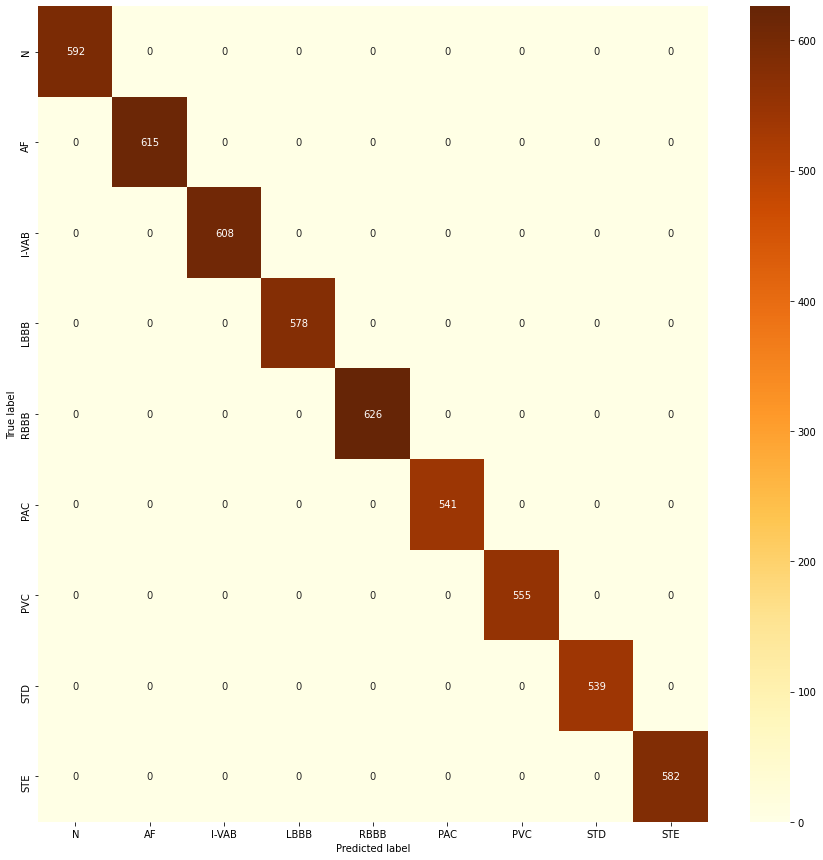

In [ ]:
make_confusion_matrix(cf_matrix,
                          categories=['N','AF','I-VAB','LBBB','RBBB','PAC','PVC','STD','STE'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='YlOrBr',
                          title=None)

In [ ]:
cf_matrix1 = confusion_matrix(srcnn_test_labels,srcnn_op_int)

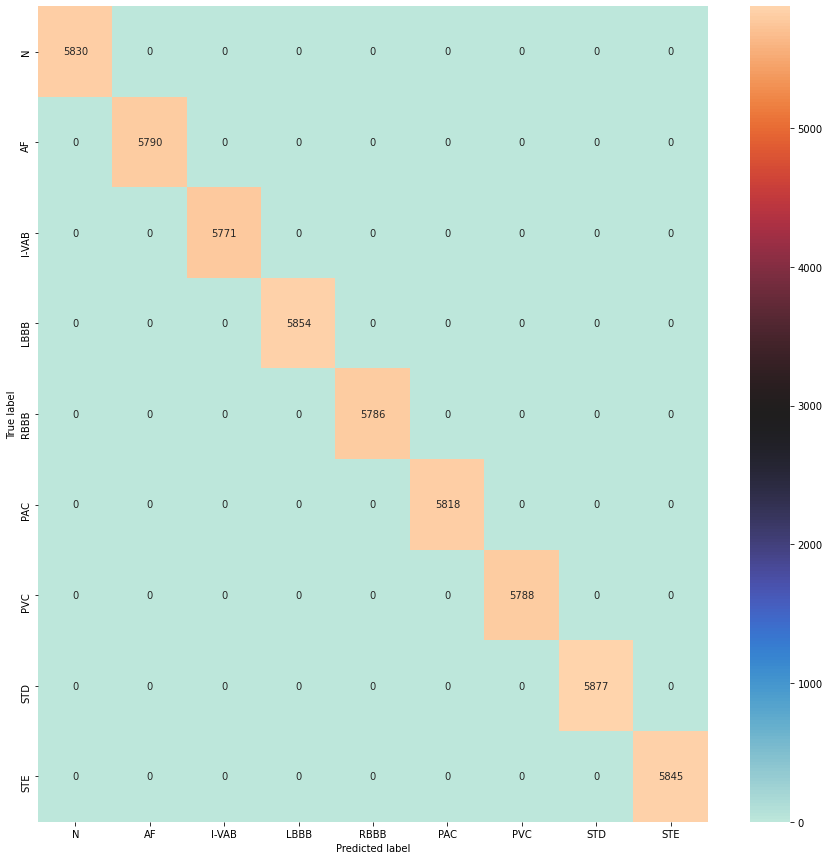

In [ ]:
make_confusion_matrix(cf_matrix1,
                          categories=['N','AF','I-VAB','LBBB','RBBB','PAC','PVC','STD','STE'],
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=(15,15),
                          cmap='icefire',
                          title=None)